In [1]:
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor, GeneralizedLinearRegression, IsotonicRegression
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes

In [2]:
spark = SparkSession.builder.appName("AirlineStatusModel_xiomara_1").config("spark.jars",\
        "path/to/your/jars").config("spark.driver.extraJavaOptions", "--illegal-access=warn").getOrCreate() 
spark.sparkContext

23/11/26 22:36:13 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


<SparkContext master=yarn appName=PySparkShell>

In [3]:
df = spark.read.csv("gs://msca-bdp-student-gcs/Group7_Final_Project/flight_status/airline_status_preprocessed.csv", 
                                     header = True, inferSchema = True)

In [4]:
df = df.withColumn("departure_delay_15", col("departure_delay_15").cast("double"))

In [ ]:
df.printSchema()

In [ ]:
df.select(['flight_date', 'origin', 'destination', 'airline', 'departure_time_formatted', 'arrival_time','departure_delay','departure_delay_mins']).show()

In [5]:
indexer_departure = StringIndexer(inputCol="origin", outputCol="departure_index")
indexer_arrival = StringIndexer(inputCol="destination", outputCol="arrival_index")
indexer_airline = StringIndexer(inputCol="airline", outputCol="airline_index")
indexer_day_of_week = StringIndexer(inputCol="day_of_week", outputCol="day_of_week_index")
indexer_month = StringIndexer(inputCol="month", outputCol="month_index")
indexer_hour_departure_time = StringIndexer(inputCol="hour_departure_time", outputCol="hour_departure_time_index")

encoder_departure = OneHotEncoder(inputCol="departure_index", outputCol="departure_onehot")
encoder_arrival = OneHotEncoder(inputCol="arrival_index", outputCol="arrival_onehot")
encoder_airline = OneHotEncoder(inputCol="airline_index", outputCol="airline_onehot")
encoder_day_of_week = OneHotEncoder(inputCol="day_of_week_index", outputCol="day_of_week_onehot")
encoder_month = OneHotEncoder(inputCol="month_index", outputCol="month_onehot")
encoder_hour_departure_time = OneHotEncoder(inputCol="hour_departure_time_index", outputCol="hour_departure_time_onehot")

In [ ]:
df.printSchema()

In [6]:
df = df.na.drop(subset=["airline", "day_of_week", \
                        "taxi_out", "crs_elapsed_time", "distance", "arrival_delay", "departure_delay"])

In [ ]:
df.select("flight_date","airline", "origin", "destination", "destination_airport_world_area_code" ).show()

### arrival_delay as the prediction label

In [7]:
selected_features = [ "day_of_week_onehot", "taxi_out","crs_elapsed_time", "distance", "departure_delay"]
assembler = VectorAssembler(
    inputCols= selected_features,
    outputCol="features"
)

pipeline = Pipeline(stages=[indexer_airline, encoder_airline, indexer_day_of_week,encoder_day_of_week, assembler])

model = pipeline.fit(df)
transformed_df = model.transform(df)

In [8]:
sampled_df = transformed_df.sample(fraction=0.1, seed=42) 

train_df, test_and_val_df = sampled_df.randomSplit([0.6, 0.4], seed=42)
test_df, validation_df = test_and_val_df.randomSplit([0.5, 0.5], seed=42)

In [9]:
lr = LinearRegression(featuresCol='features', labelCol='arrival_delay', regParam=0.3, elasticNetParam=0.8, maxIter=10)
lr_model = lr.fit(train_df)
predictions_lr_train = lr_model.transform(train_df)
predictions_lr_validation = lr_model.transform(validation_df)
predictions_lr_test = lr_model.transform(test_df)

In [10]:
dt_reg = DecisionTreeRegressor(featuresCol='features', labelCol='arrival_delay', maxDepth=5)
dt_model_reg = dt_reg.fit(train_df)
predictions_dt_train = dt_model_reg.transform(train_df)
predictions_dt_validation = dt_model_reg.transform(validation_df)
predictions_dt_test = dt_model_reg.transform(test_df)

In [11]:
rf_reg = RandomForestRegressor(featuresCol='features', labelCol='arrival_delay', numTrees=10)
rf_model_reg = rf_reg.fit(train_df)
predictions_rf_train = rf_model_reg.transform(train_df)
predictions_rf_validation = rf_model_reg.transform(validation_df)
predictions_rf_test = rf_model_reg.transform(test_df)

In [12]:
gbt_reg = GBTRegressor(featuresCol='features', labelCol='arrival_delay', maxIter=10)
gbt_model_reg = gbt_reg.fit(train_df)
predictions_gbt_train = gbt_model_reg.transform(train_df)
predictions_gbt_validation = gbt_model_reg.transform(validation_df)
predictions_gbt_test = gbt_model_reg.transform(test_df)

In [13]:
glr = GeneralizedLinearRegression(featuresCol='features', labelCol='arrival_delay', family='gaussian', link='identity', maxIter=10)
glr_model = glr.fit(train_df)
predictions_glr_train = glr_model.transform(train_df)
predictions_glr_validation = glr_model.transform(validation_df)
predictions_glr_test = glr_model.transform(test_df)

23/11/26 22:57:27 WARN Instrumentation: [f5656a17] regParam is zero, which might cause numerical instability and overfitting.


In [44]:
regression_evaluator_rmse = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="rmse")
regression_evaluator_mae = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="mae")
regression_evaluator_r2 = RegressionEvaluator(labelCol="arrival_delay", predictionCol="prediction", metricName="r2")

models_regression = {
    "Linear Regression": [predictions_lr_test, predictions_lr_train, predictions_lr_validation],
    "Decision Trees": [predictions_dt_test, predictions_dt_train, predictions_dt_validation],
    "Random Forest": [predictions_rf_test, predictions_rf_train, predictions_rf_validation], 
    "GBT": [predictions_gbt_test, predictions_gbt_train, predictions_gbt_validation],
    "Generalized Linear Regression": [predictions_glr_test, predictions_glr_train, predictions_glr_validation]
}

for model_name, predictions in models_regression.items():
    test, train, val = predictions
   
    rmse_test = regression_evaluator_rmse.evaluate(test)
    mae_test = regression_evaluator_mae.evaluate(test)
    r2_test = regression_evaluator_r2.evaluate(test)
    
    rmse_train = regression_evaluator_rmse.evaluate(train)
    mae_train = regression_evaluator_mae.evaluate(train)
    r2_train = regression_evaluator_r2.evaluate(train)
    
    rmse_val = regression_evaluator_rmse.evaluate(val)
    mae_val = regression_evaluator_mae.evaluate(val)
    r2_val = regression_evaluator_r2.evaluate(val)
    
    print(f"{model_name} Train - RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R-squared: {r2_train:.4f}")
    print(f"{model_name} Test - RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R-squared: {r2_test:.4f}")
    print(f"{model_name} Validation - RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R-squared: {r2_val:.4f}")

Linear Regression Train - RMSE: 10.7856, MAE: 7.7855, R-squared: 0.9490
Linear Regression Test - RMSE: 10.7652, MAE: 7.7718, R-squared: 0.9515
Linear Regression Validation - RMSE: 10.7853, MAE: 7.7964, R-squared: 0.9504


Decision Trees Train - RMSE: 29.0831, MAE: 11.2264, R-squared: 0.6295
Decision Trees Test - RMSE: 30.6460, MAE: 11.3239, R-squared: 0.6071
Decision Trees Validation - RMSE: 29.8494, MAE: 11.3274, R-squared: 0.6203


Random Forest Train - RMSE: 29.6880, MAE: 12.2218, R-squared: 0.6139
Random Forest Test - RMSE: 31.1747, MAE: 12.3049, R-squared: 0.5935
Random Forest Validation - RMSE: 30.4542, MAE: 12.3302, R-squared: 0.6047


GBT Train - RMSE: 28.8624, MAE: 10.5791, R-squared: 0.6351
GBT Test - RMSE: 30.4628, MAE: 10.6641, R-squared: 0.6118
GBT Validation - RMSE: 29.6567, MAE: 10.6833, R-squared: 0.6251


Generalized Linear Regression Train - RMSE: 10.3999, MAE: 7.3885, R-squared: 0.9526
Generalized Linear Regression Test - RMSE: 10.3506, MAE: 7.3659, R-squared: 0.9552
Generalized Linear Regression Validation - RMSE: 10.3738, MAE: 7.3850, R-squared: 0.9541


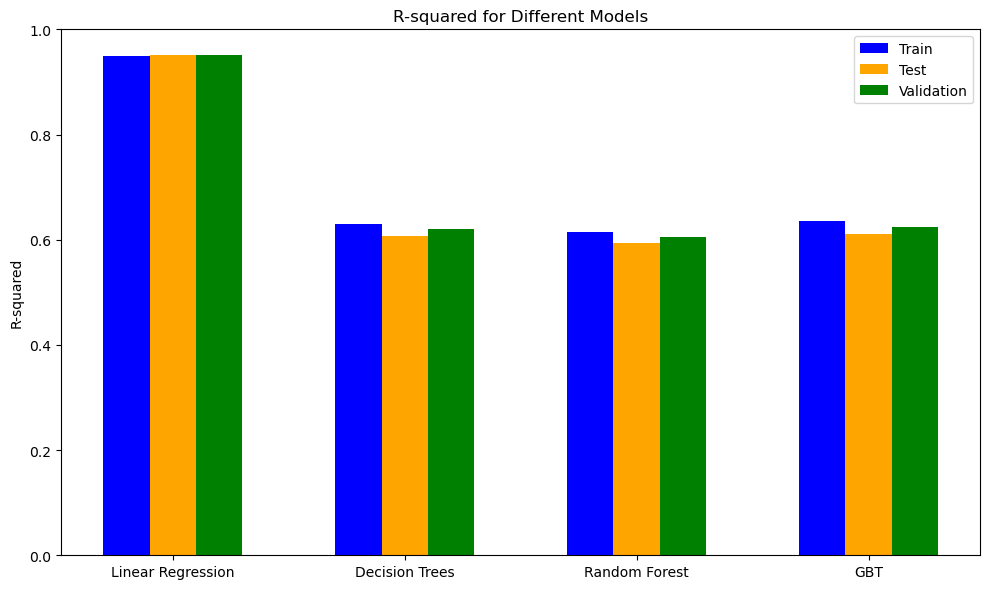

In [8]:
import numpy as np

models = ["Linear Regression", "Decision Trees", "Random Forest", "GBT"]
train_r2 = [0.9490, 0.6295, 0.6139, 0.6351]
test_r2 = [0.9515, 0.6071, 0.5935, 0.6118]
validation_r2 = [0.9504, 0.6203, 0.6047, 0.6251]

bar_width = 0.2
index = np.arange(len(models))

plt.figure(figsize=(10, 6))

plt.bar(index - bar_width, train_r2, bar_width, label='Train', color='blue')
plt.bar(index, test_r2, bar_width, label='Test', color='orange')
plt.bar(index + bar_width, validation_r2, bar_width, label='Validation', color='green')

plt.title('R-squared for Different Models')
plt.ylabel('R-squared')
plt.ylim(0, 1)
plt.xticks(index, models)
plt.legend()

plt.tight_layout()
plt.show()

### Switch to departure_delay as label and adding weather data to help
Was not successful with flight status data only (R^2 of .02)

In [6]:
weather_df = spark.read.csv("gs://msca-bdp-student-gcs/Group7_Final_Project/flight_status/airport_weather/airport_weather_preprocessed.csv", 
                                     header = True, inferSchema = True)

In [7]:
df.createOrReplaceTempView("flight_status")
weather_df.createOrReplaceTempView("weather")


query = """
        SELECT *
        FROM flight_status flight
        JOIN weather
        ON (DATE(flight.flight_date) = DATE(weather.start_time_utc)
        AND flight.origin = weather.iata)
"""

result_df = spark.sql(query)


23/11/25 22:40:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
result_df = result_df.na.drop(subset=["severity", "type" ])

In [72]:
print(f"This is the original df count {df.count()}")
print(f"This is the result df count {result_df.count()}")

This is the original df count 24394687


This is the result df count 34276978


In [12]:
result_df.printSchema()

root
 |-- flight_date: timestamp (nullable = true)
 |-- airline: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- cancelled: boolean (nullable = true)
 |-- diverted: boolean (nullable = true)
 |-- crs_departure_time: integer (nullable = true)
 |-- departure_time: integer (nullable = true)
 |-- departure_delay_mins: double (nullable = true)
 |-- departure_delay: double (nullable = true)
 |-- arrival_time: integer (nullable = true)
 |-- arrival_delay_mins: double (nullable = true)
 |-- air_time: double (nullable = true)
 |-- crs_elapsed_time: double (nullable = true)
 |-- actual_elapsed_time: double (nullable = true)
 |-- distance: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- marketing_airline_network: string (nullable = true)
 |-- flight_nu

In [9]:
indexer_departure = StringIndexer(inputCol="origin", outputCol="departure_index")
indexer_arrival = StringIndexer(inputCol="destination", outputCol="arrival_index")
indexer_airline = StringIndexer(inputCol="airline", outputCol="airline_index")
indexer_day_of_week = StringIndexer(inputCol="day_of_week", outputCol="day_of_week_index")
indexer_month = StringIndexer(inputCol="month", outputCol="month_index")
indexer_type= StringIndexer(inputCol="type", outputCol="type_index")
indexer_severity= StringIndexer(inputCol="severity", outputCol="severity_index")

encoder_departure = OneHotEncoder(inputCol="departure_index", outputCol="departure_onehot")
encoder_arrival = OneHotEncoder(inputCol="arrival_index", outputCol="arrival_onehot")
encoder_airline = OneHotEncoder(inputCol="airline_index", outputCol="airline_onehot")
encoder_day_of_week = OneHotEncoder(inputCol="day_of_week_index", outputCol="day_of_week_onehot")
encoder_month = OneHotEncoder(inputCol="month_index", outputCol="month_onehot")
encoder_type= OneHotEncoder(inputCol="type_index", outputCol="type_onehot")
encoder_severity= OneHotEncoder(inputCol="severity_index", outputCol="severity_onehot")

In [10]:
selected_features = ["departure_onehot", "arrival_onehot","day_of_week_onehot", "distance",\
                   "distance","type_onehot", "severity_onehot"]

assembler = VectorAssembler(
    inputCols= selected_features,
    outputCol="features"
)

pipeline = Pipeline(stages=[indexer_departure, indexer_arrival, indexer_day_of_week,\
                            indexer_type, indexer_severity, encoder_departure, encoder_day_of_week,\
                            encoder_arrival, encoder_type, encoder_severity, assembler])
model = pipeline.fit(result_df)
transformed_df = model.transform(result_df)



In [13]:
sampled_df = transformed_df.sample(fraction=0.1, seed=42) 

train_df, test_and_val_df = sampled_df.randomSplit([0.6, 0.4], seed=42)
test_df, validation_df = test_and_val_df.randomSplit([0.5, 0.5], seed=42)

In [21]:
train_df.show()

+-------------------+--------------------+------+-----------+---------+--------+------------------+--------------+--------------------+---------------+------------+------------------+--------+----------------+-------------------+--------+----+-------+-----+------------+-----------+-------------------------+-------------------------------+-----------------+-----------+-------------------------------+-----------------+---------------------+---------------------+----------------+------------+-----------------+-----------------+------------------------------+----------------------+--------------------------+--------------------------+---------------------+-----------------+----------------------+----------------------+-----------------------------------+------------------+----------------------+--------------------+--------+----------+---------+-------+----------------+-------------+----------------+--------------------+------------------+--------------+-------------------------+----------

In [14]:
lr = LinearRegression(featuresCol='features', labelCol='departure_delay', regParam=0.3, elasticNetParam=0.8, maxIter=10)
lr_model = lr.fit(train_df)
predictions_lr_train = lr_model.transform(train_df)
predictions_lr_validation = lr_model.transform(validation_df)
predictions_lr_test = lr_model.transform(test_df)

In [15]:
dt_reg = DecisionTreeRegressor(featuresCol='features', labelCol='departure_delay', maxDepth=5)
dt_model_reg = dt_reg.fit(train_df)
predictions_dt_train = dt_model_reg.transform(train_df)
predictions_dt_validation = dt_model_reg.transform(validation_df)
predictions_dt_test = dt_model_reg.transform(test_df)

In [16]:
rf_reg = RandomForestRegressor(featuresCol='features', labelCol='departure_delay', numTrees=10)
rf_model_reg = rf_reg.fit(train_df)
predictions_rf_train = rf_model_reg.transform(train_df)
predictions_rf_validation = rf_model_reg.transform(validation_df)
predictions_rf_test = rf_model_reg.transform(test_df)

In [17]:
gbt_reg = GBTRegressor(featuresCol='features', labelCol='departure_delay', maxIter=10)
gbt_model_reg = gbt_reg.fit(train_df)
predictions_gbt_train = gbt_model_reg.transform(train_df)
predictions_gbt_validation = gbt_model_reg.transform(validation_df)
predictions_gbt_test = gbt_model_reg.transform(test_df)

In [18]:
glr = GeneralizedLinearRegression(featuresCol='features', labelCol='departure_delay', family='gaussian', link='identity', maxIter=10)
glr_model = glr.fit(train_df)
predictions_glr_train = glr_model.transform(train_df)
predictions_glr_validation = glr_model.transform(validation_df)
predictions_glr_test = glr_model.transform(test_df)

23/11/25 23:29:57 WARN Instrumentation: [4a850339] regParam is zero, which might cause numerical instability and overfitting.
23/11/25 23:31:15 WARN Instrumentation: [4a850339] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [19]:
regression_evaluator_rmse = RegressionEvaluator(labelCol="departure_delay", predictionCol="prediction", metricName="rmse")
regression_evaluator_mae = RegressionEvaluator(labelCol="departure_delay", predictionCol="prediction", metricName="mae")
regression_evaluator_r2 = RegressionEvaluator(labelCol="departure_delay", predictionCol="prediction", metricName="r2")

In [20]:
models_regression = {
    "Linear Regression": [predictions_lr_test, predictions_lr_train, predictions_lr_validation],
    "Decision Trees": [predictions_dt_test, predictions_dt_train, predictions_dt_validation],
    "Random Forest": [predictions_rf_test, predictions_rf_train, predictions_rf_validation], 
    "GBT": [predictions_gbt_test, predictions_gbt_train, predictions_gbt_validation],
    "Generalized Linear Regression": [predictions_glr_test, predictions_glr_train, predictions_glr_validation]
}

for model_name, predictions in models_regression.items():
    test, train, val = predictions
   
    rmse_test = regression_evaluator_rmse.evaluate(test)
    mae_test = regression_evaluator_mae.evaluate(test)
    r2_test = regression_evaluator_r2.evaluate(test)
    
    rmse_train = regression_evaluator_rmse.evaluate(train)
    mae_train = regression_evaluator_mae.evaluate(train)
    r2_train = regression_evaluator_r2.evaluate(train)
    
    rmse_val = regression_evaluator_rmse.evaluate(val)
    mae_val = regression_evaluator_mae.evaluate(val)
    r2_val = regression_evaluator_r2.evaluate(val)
    
    print(f"{model_name} Train - RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R-squared: {r2_train:.4f}")
    print(f"{model_name} Test - RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R-squared: {r2_test:.4f}")
    print(f"{model_name} Validation - RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R-squared: {r2_val:.4f}")

Linear Regression Train - RMSE: 57.3916, MAE: 27.6419, R-squared: 0.0103
Linear Regression Test - RMSE: 57.2918, MAE: 27.5841, R-squared: 0.0098
Linear Regression Validation - RMSE: 58.1119, MAE: 27.6777, R-squared: 0.0105


Decision Trees Train - RMSE: 58.3105, MAE: 27.7367, R-squared: 0.0059
Decision Trees Test - RMSE: 57.5352, MAE: 27.7974, R-squared: 0.0019
Decision Trees Validation - RMSE: 58.2015, MAE: 27.9544, R-squared: 0.0049


Random Forest Train - RMSE: 57.9098, MAE: 27.8078, R-squared: 0.0074
Random Forest Test - RMSE: 57.3487, MAE: 27.7595, R-squared: 0.0066
Random Forest Validation - RMSE: 57.2050, MAE: 27.8687, R-squared: 0.0070


GBT Train - RMSE: 57.9690, MAE: 27.6786, R-squared: 0.0107
GBT Test - RMSE: 57.6096, MAE: 27.6720, R-squared: 0.0075
GBT Validation - RMSE: 58.1410, MAE: 27.6543, R-squared: 0.0110


Generalized Linear Regression Train - RMSE: 57.8950, MAE: 27.5254, R-squared: 0.0126
Generalized Linear Regression Test - RMSE: 57.9364, MAE: 27.4868, R-squared: 0.0117
Generalized Linear Regression Validation - RMSE: 57.5980, MAE: 27.6220, R-squared: 0.0126
